## Validation process

    #results for -30ft, -20ft, and -10ft

In [10]:
#General libraries DEM Bathymetry
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patheffects as pe
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

#General libraries HEC-RAS
import h5py
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import matplotlib.dates as mdates

#Error metrics libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error



## Cross Sections locations

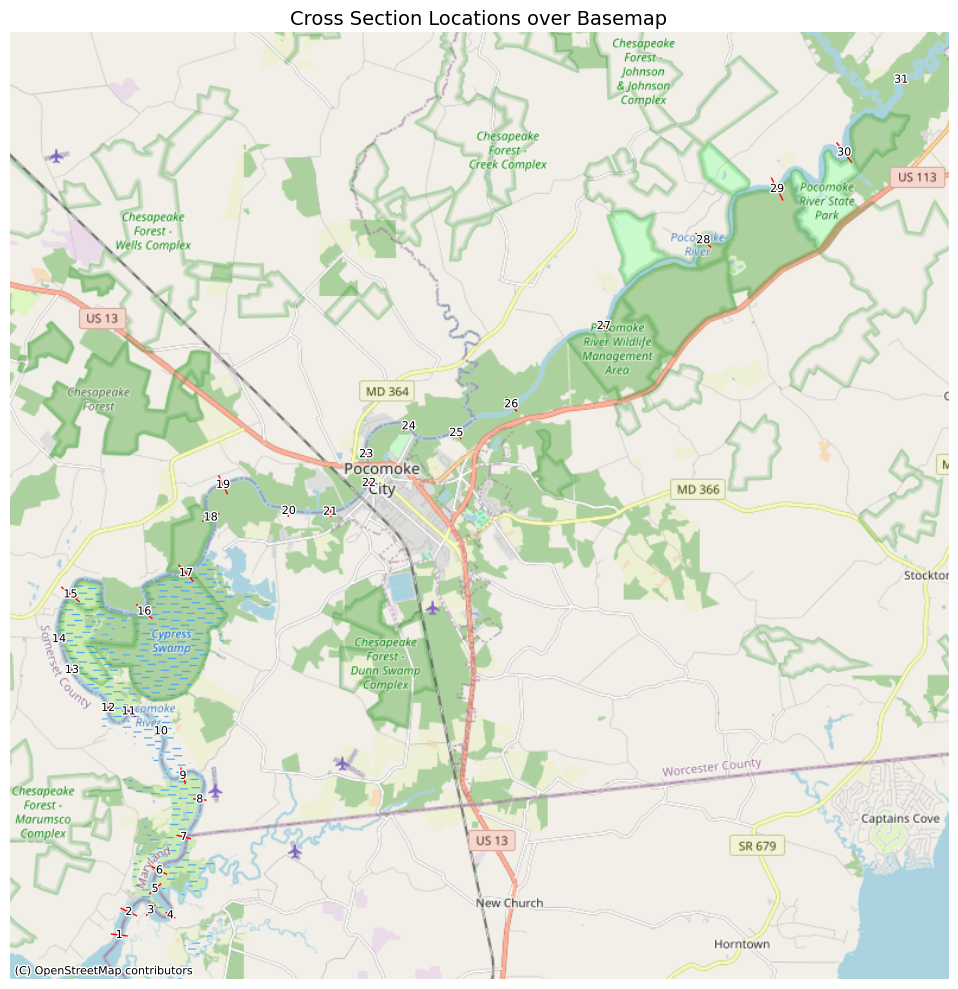

In [140]:
#Load your shapefile
lines_gdf = gpd.read_file(r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Cross.shp")

#Convert to Web Mercator (required for basemap tiles)
lines_gdf = lines_gdf.to_crs(epsg=3857)

#Plot
fig, ax = plt.subplots(figsize=(12, 10))
lines_gdf.plot(ax=ax, edgecolor='red', linewidth=1)

# Label each cross-section
for idx, row in lines_gdf.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(x, y, str(idx + 1), fontsize=8, ha='center', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='white')])

# Add basemap (OpenStreetMap by default)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Format
ax.set_title("Cross Section Locations over Basemap", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


##  Coastal validation

# Boundary Condition data
(Sheltown gage)


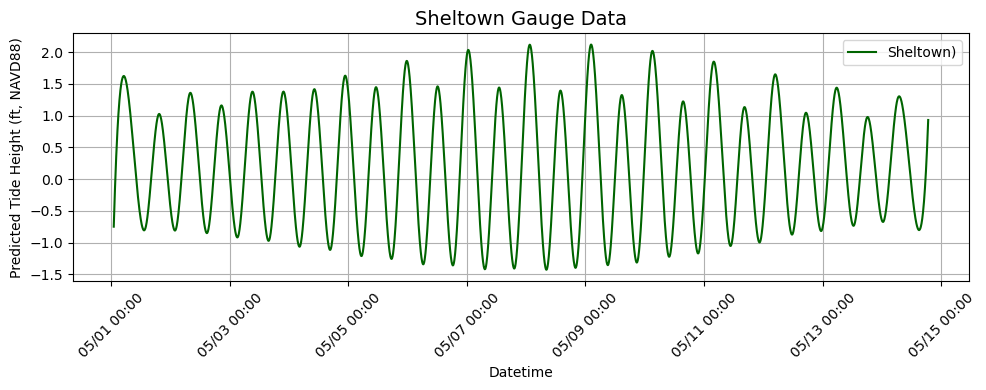

In [ ]:
#Gauge plot -#Sheltown gauge data - BC

# === File path ===
excel_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\BC_sheltown\tides_6min_spline.xlsx"

# === Load Sheet2
df = pd.read_excel(excel_path, sheet_name="Sheet1")

# === Clean column names and rename
df.columns = df.columns.str.strip().str.replace('\n', ' ', regex=True)
df.rename(columns={
    df.columns[0]: "Datetime",
    df.columns[1]: "Water Level (ft)",
}, inplace=True)

# === Plot with full datetime labels
plt.figure(figsize=(10, 4))
plt.plot(df["Datetime"], df["Water Level (ft)"], label="Sheltown)", color='darkgreen')
plt.title("Sheltown Gauge Data", fontsize=14)
plt.xlabel("Datetime")
plt.ylabel("Predicted Tide Height (ft, NAVD88)")
plt.grid(True)

# Format x-axis to show both date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend()
plt.show()

# Manning = 0.01 (Pocomoke River)
    -30ft channel 


##Results for 31 cross sections  
  #I am using the small geometry for the river

C:\Users\dveronez\AppData\Local\Temp\ipykernel_24188\131319851.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  river_union = river_gdf.unary_union  # merge all polygons into one “Load my river shapefile, and if it has multiple parts, merge them into one single river shape so I can test if each mesh cell is inside the river.”


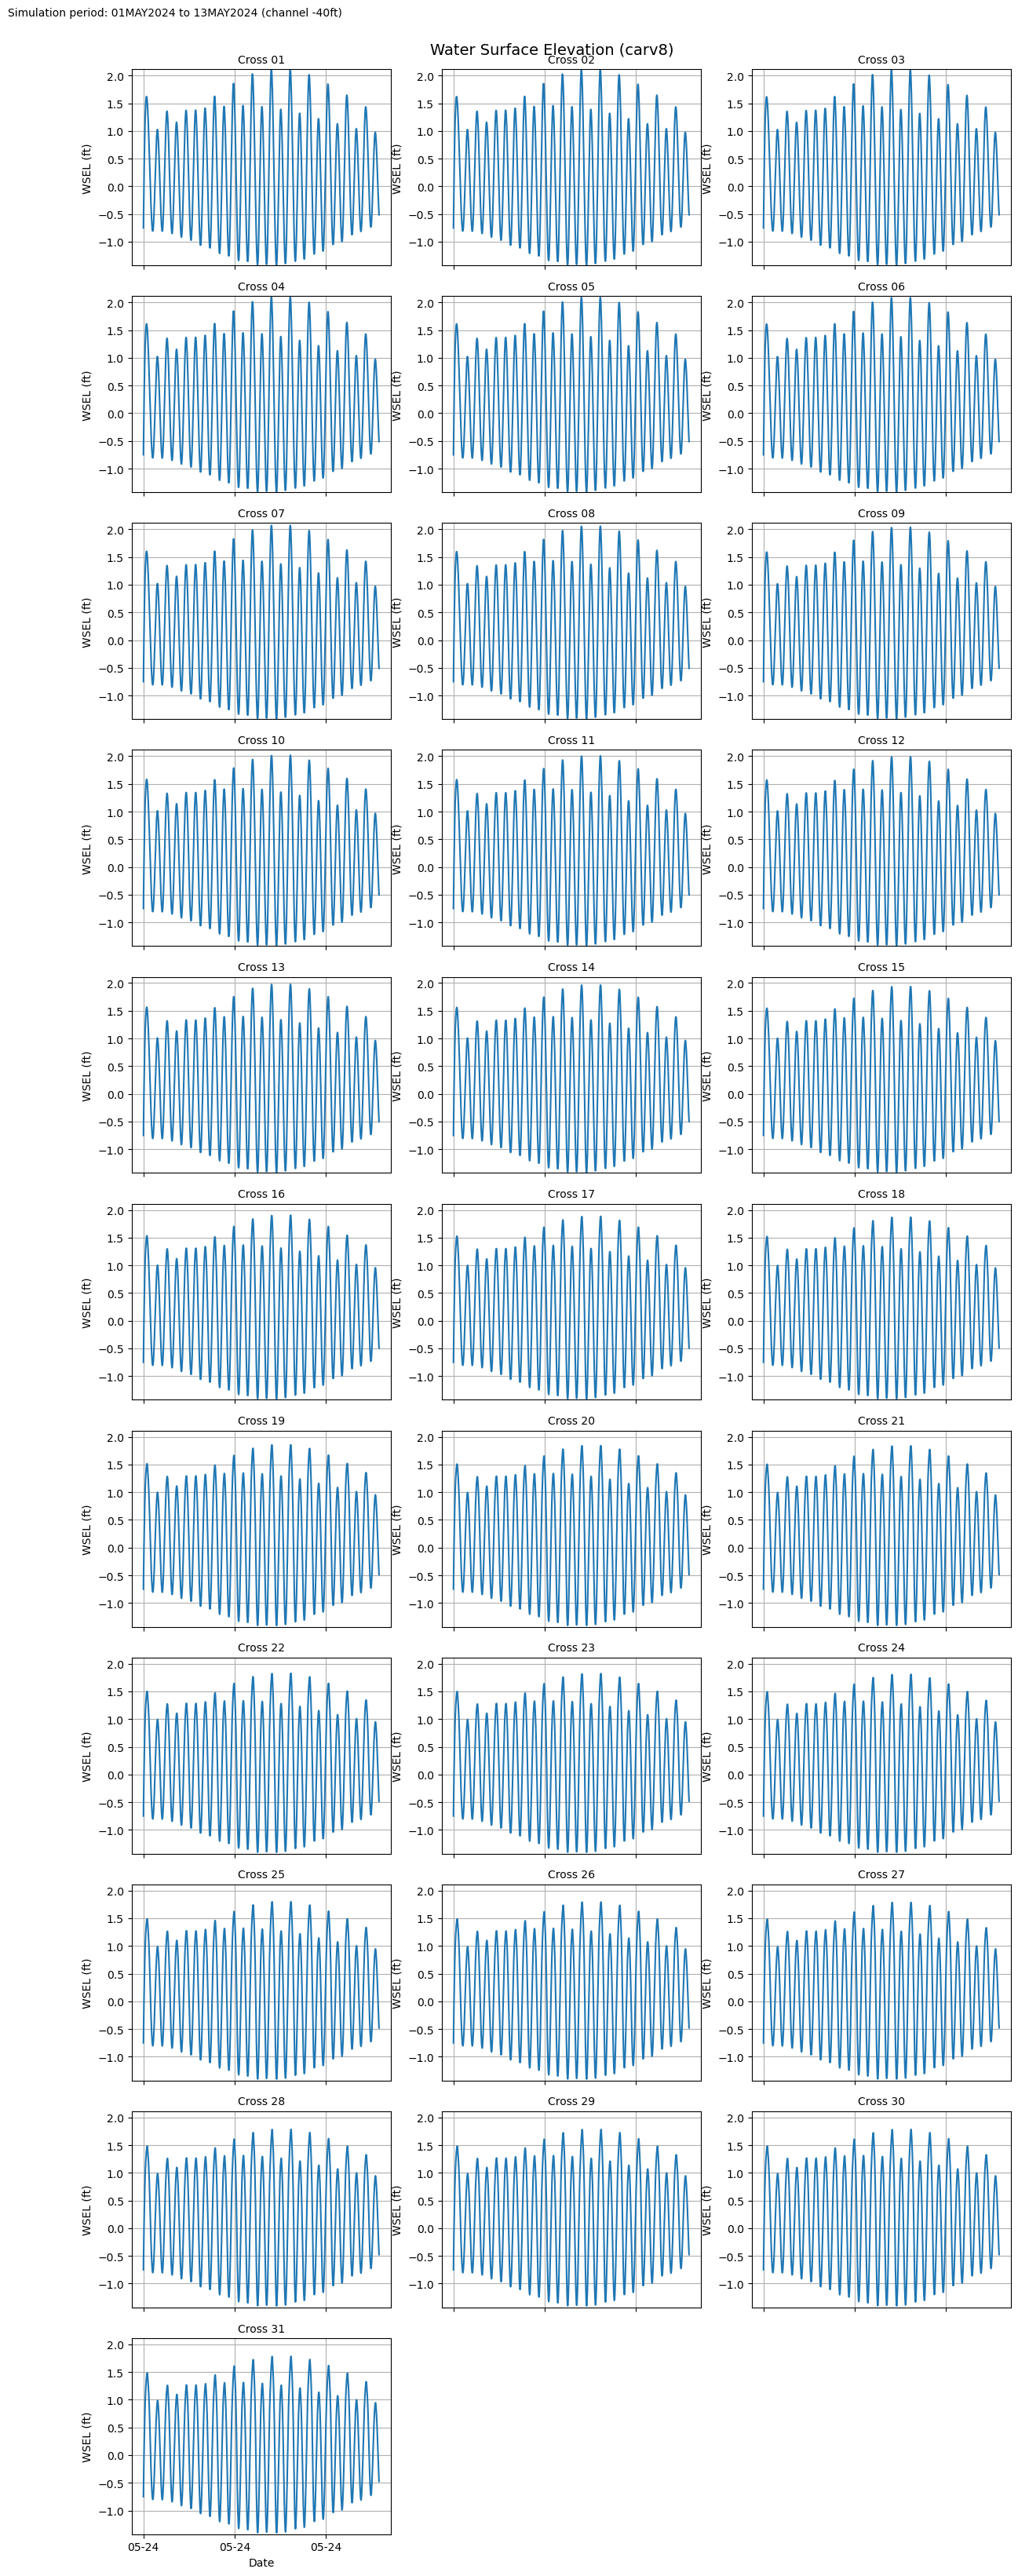

In [11]:
#select cell IDs for cross sections and river polygon

# === PATHS ===
hdf_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\BC_sheltown\hec67\GRIVERv5.p86.hdf"
cross_path = r'C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Cross.shp'
river_path = r'C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\PocomokeRiverPol.shp'

# === LOAD RIVER POLYGON ===
river_gdf = gpd.read_file(river_path)
river_union = river_gdf.unary_union  # merge all polygons into one “Load my river shapefile, and if it has multiple parts, merge them into one single river shape so I can test if each mesh cell is inside the river.”

# === LOAD HDF AND EXTRACT COORDS ===
with h5py.File(hdf_path, 'r') as f:
    coords = f['/Geometry/2D Flow Areas/Perimeter_River/Cells Center Coordinate'][:]
    cell_points = [Point(xy) for xy in coords]

    time_minutes = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time'][:]
    start_str = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time Date Stamp'][0].decode()
    start_datetime = datetime.strptime(start_str, '%d%b%Y %H:%M:%S')
    time_index = [start_datetime + timedelta(minutes=float(t)) for t in time_minutes]

    ws_all = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/Perimeter_River/Water Surface'][:]

# === KEEP ONLY CELLS INSIDE RIVER POLYGON ===
river_cell_indexes = [i for i, pt in enumerate(cell_points) if pt.within(river_union)]

# === LOAD CROSS SECTIONS AND GET MIDPOINTS ===
cross_gdf = gpd.read_file(cross_path)
midpoints = cross_gdf.geometry.interpolate(0.5, normalized=True)

# === MATCH EACH CROSS MIDPOINT TO CLOSEST CELL WITHIN RIVER ===
selected_indexes = []
cell_to_cross = {}
for i, midpt in enumerate(midpoints):
    river_cell_pts = [cell_points[i] for i in river_cell_indexes]
    distances = [midpt.distance(pt) for pt in river_cell_pts]
    if distances:
        closest_idx_in_river = river_cell_indexes[np.argmin(distances)]
        selected_indexes.append(closest_idx_in_river)
        cell_to_cross[closest_idx_in_river] = f"Cross {i+1:02d}"
    else:
        print(f"⚠️ No river cell found for Cross {i+1:02d} — fallback to global nearest")
        distances_all = [midpt.distance(pt) for pt in cell_points]
        fallback_idx = np.argmin(distances_all)
        selected_indexes.append(fallback_idx)
        cell_to_cross[fallback_idx] = f"Cross {i+1:02d}"

# === BUILD WSEL DATAFRAME ===
wsel_data = {}
for idx in selected_indexes:
    ws = ws_all[:, idx]
    wsel_data[f'Cell_{idx}'] = ws

wsel_df = pd.DataFrame(wsel_data, index=pd.to_datetime(time_index))
wsel_df.index.name = 'Datetime'

# === PLOTTING ===
global_min = wsel_df.min().min()
global_max = wsel_df.max().max()
num_cells = len(wsel_df.columns)
cols = 3
rows = math.ceil(num_cells / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True)
axes = axes.flatten()

for i, col in enumerate(wsel_df.columns):
    idx = int(col.replace("Cell_", ""))
    cross_name = cell_to_cross.get(idx, col)

    ax = axes[i]
    ax.plot(wsel_df.index, wsel_df[col])
    ax.set_title(cross_name, fontsize=10)
    ax.set_ylabel("WSEL (ft)")
    ax.set_ylim(global_min, global_max)
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

    if i >= (rows - 1) * cols:
        ax.set_xlabel("Date")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Water Surface Elevation (carv8)", fontsize=14)
fig.text(0.1, 0.99, "Simulation period: 01MAY2024 to 13MAY2024 (channel -40ft)", ha='center', fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

#Compare model results and Shelltown gauge: Reference:  cross 2

#Compare model results and Snow Hill gauge: Reference cross 31

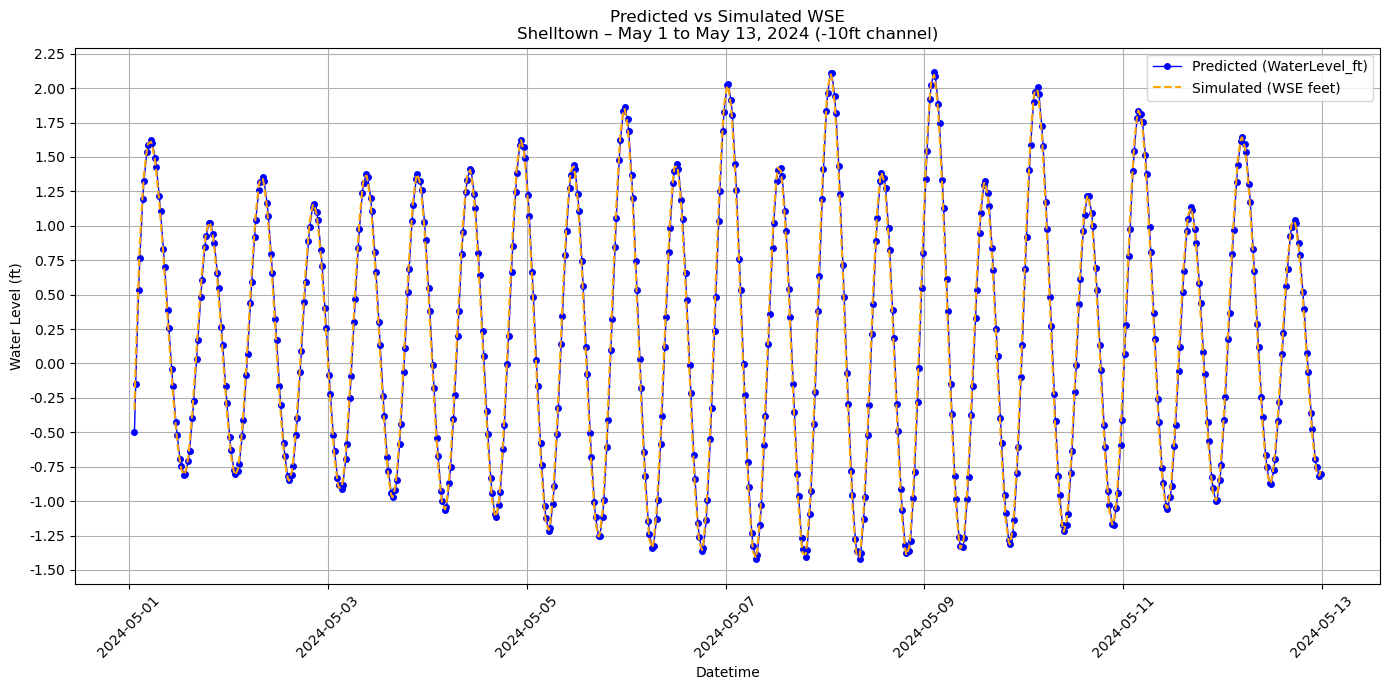

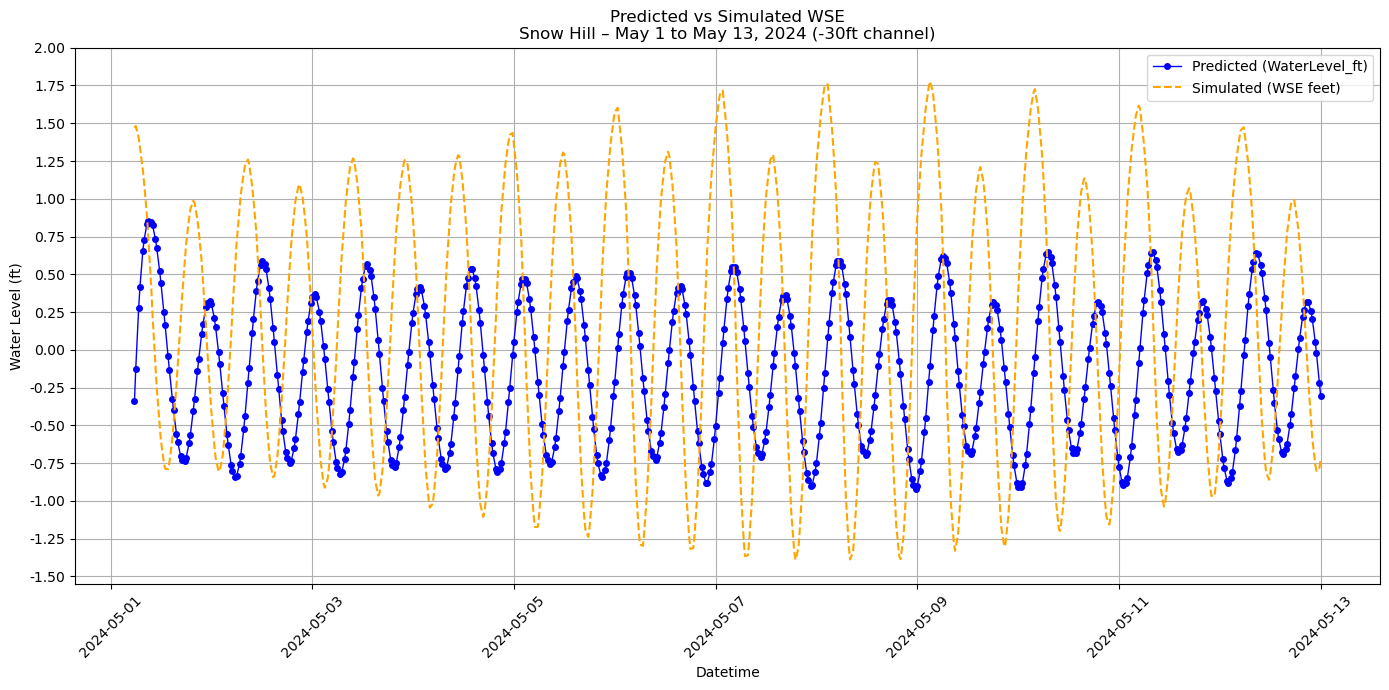

In [12]:
# === File paths ===
file_obs_snow = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\BC_sheltown\tides_6min_spline_snow.xlsx"
file_obs_shel = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\BC_sheltown\tides_6min_spline_Shel.xlsx"
file_sim = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\BC_sheltown\hec67\WSEL_cross_Griver001.csv"

# === Load simulation data ===
df_sim = pd.read_csv(file_sim)


# === Extract relevant columns for Shelltown (C) and Snow Hill (AF) ===
df_sim_shel = df_sim[['Datetime', 'Cell_221872']].copy()
df_sim_snow = df_sim[['Datetime', 'Cell_29701']].copy()
df_sim_shel.columns = ['Datetime', 'WSE (feet)']
df_sim_snow.columns = ['Datetime', 'WSE (feet)']
df_sim_shel['Datetime'] = pd.to_datetime(df_sim_shel['Datetime'])
df_sim_snow['Datetime'] = pd.to_datetime(df_sim_snow['Datetime'])

# === Load observed data ===
df_obs_shel = pd.read_excel(file_obs_shel)
df_obs_snow = pd.read_excel(file_obs_snow)
df_obs_shel.columns = df_obs_shel.columns.str.strip()
df_obs_snow.columns = df_obs_snow.columns.str.strip()
df_obs_shel['Datetime'] = pd.to_datetime(df_obs_shel['DateTime'])
df_obs_snow['Datetime'] = pd.to_datetime(df_obs_snow['DateTime'])

# === Define date range ===
start_date = pd.to_datetime("2024-05-01")
end_date = pd.to_datetime("2024-05-13")

# === Filter observed data by date range ===
df_obs_shel_filtered = df_obs_shel[(df_obs_shel['Datetime'] >= start_date) & (df_obs_shel['Datetime'] <= end_date)]
df_obs_snow_filtered = df_obs_snow[(df_obs_snow['Datetime'] >= start_date) & (df_obs_snow['Datetime'] <= end_date)]

# === Interpolate simulated and reindex on observed time ===
sim_interp_shel = df_sim_shel.set_index('Datetime')['WSE (feet)'].interpolate(method='time')
sim_on_obs_time_shel = sim_interp_shel.reindex(df_obs_shel_filtered['Datetime'], method='nearest', tolerance=pd.Timedelta('1min'))

sim_interp_snow = df_sim_snow.set_index('Datetime')['WSE (feet)'].interpolate(method='time')
sim_on_obs_time_snow = sim_interp_snow.reindex(df_obs_snow_filtered['Datetime'], method='nearest', tolerance=pd.Timedelta('1min'))

# === Create dataframes for plotting ===
df_plot_shel = pd.DataFrame({
    'Datetime': df_obs_shel_filtered['Datetime'],
    'Observed': df_obs_shel_filtered['WaterLevel_ft'].values,
    'Simulated': sim_on_obs_time_shel.values
}).dropna()

df_plot_snow = pd.DataFrame({
    'Datetime': df_obs_snow_filtered['Datetime'],
    'Observed': df_obs_snow_filtered['WaterLevel_ft'].values,
    'Simulated': sim_on_obs_time_snow.values
}).dropna()

# === Plot Shelltown ===
plt.figure(figsize=(14, 7))
plt.plot(df_plot_shel['Datetime'], df_plot_shel['Observed'],
         label='Predicted (WaterLevel_ft)', color='blue', linestyle='-', marker='o', markersize=4, linewidth=1)
plt.plot(df_plot_shel['Datetime'], df_plot_shel['Simulated'],
         label='Simulated (WSE feet)', color='orange', linestyle='--', linewidth=1.5)
y_min = df_plot_shel[['Observed', 'Simulated']].min().min() - 0.05
y_max = df_plot_shel[['Observed', 'Simulated']].max().max() + 0.05
yticks = np.arange(np.floor(y_min * 4) / 4, np.ceil(y_max * 4) / 4 + 0.25, 0.25)
plt.yticks(yticks, [f"{tick:.2f}" for tick in yticks])
plt.title('Predicted vs Simulated WSE\nShelltown – May 1 to May 13, 2024 (-10ft channel)')
plt.xlabel('Datetime')
plt.ylabel('Water Level (ft)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Plot Snow Hill ===
plt.figure(figsize=(14, 7))
plt.plot(df_plot_snow['Datetime'], df_plot_snow['Observed'],
         label='Predicted (WaterLevel_ft)', color='blue', linestyle='-', marker='o', markersize=4, linewidth=1)
plt.plot(df_plot_snow['Datetime'], df_plot_snow['Simulated'],
         label='Simulated (WSE feet)', color='orange', linestyle='--', linewidth=1.5)
y_min = df_plot_snow[['Observed', 'Simulated']].min().min() - 0.05
y_max = df_plot_snow[['Observed', 'Simulated']].max().max() + 0.05
yticks = np.arange(np.floor(y_min * 4) / 4, np.ceil(y_max * 4) / 4 + 0.25, 0.25)
plt.yticks(yticks, [f"{tick:.2f}" for tick in yticks])
plt.title('Predicted vs Simulated WSE\nSnow Hill – May 1 to May 13, 2024 (-30ft channel)')
plt.xlabel('Datetime')
plt.ylabel('Water Level (ft)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
